In [1]:
import torch
from torch import optim

import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as functional
from torch.utils.data import DataLoader

import clip
import json

from collate_fn_coco import collate_fn_coco
from boxclip import BOXCLIP
from transformer import *

from d2l import torch as d2l
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
checkpoint_path = './checkpoint/07-25-01-06/{}'
checkpoint_name = 'checkpoint-epoch30.pth.tar'

checkpoint = torch.load(checkpoint_path.format(checkpoint_name))

In [17]:
# load dataset
root_train = '/userhome/37/ywguo/summer-intern/datasets/train2017'
ann_file_train = '/userhome/37/ywguo/summer-intern/datasets/annotations/instances_train2017_new.json'

root_val = '/userhome/37/ywguo/summer-intern/datasets/val2017'
ann_file_val = '/userhome/37/ywguo/summer-intern/datasets/annotations/instances_val2017_new.json'

coco_train = datasets.CocoDetection(root_train, ann_file_train, 
                                    transform=transforms.Compose([transforms.ToTensor()]))
coco_val = datasets.CocoDetection(root_val, ann_file_val, 
                                  transform=transforms.Compose([transforms.ToTensor()]))

print(f'training set scale: {len(coco_train)}')
print(f'validation set scale: {len(coco_val)}')

loading annotations into memory...
Done (t=17.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
training set scale: 21391
validation set scale: 925


In [4]:
with open(ann_file_val) as f:
    data = json.load(f)
    all_cats = data['categories']
    categories = {}
    for c in all_cats:
        categories[c['id']] = c['name']

In [6]:
device = "cuda" if torch.cuda.is_available else "cpu"

# checkpoint_path = './model/07-19-11-36/{}'
# checkpoint_name = 'boxclip-07-19-13-49-epoch-9.pkl'

# load clip model and frozen its parameters
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False
    
# build our model
encoder = Encoder_TRANSFORMER(num_layers=4)
decoder = Decoder_TRANSFORMER(num_layers=4)
model = BOXCLIP(encoder=encoder, decoder=decoder, clip_model=clip_model, 
                categories=categories, device=device).to(device)

# load model from the disk
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

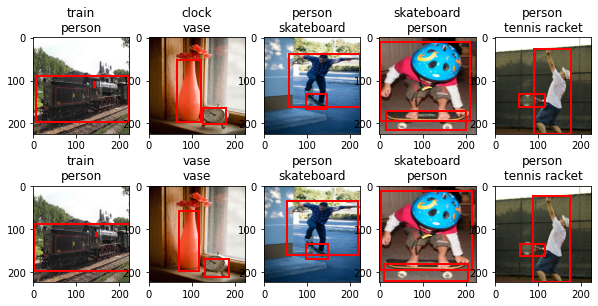

In [21]:
dataloader = torch.utils.data.DataLoader(coco_train, batch_size=5, shuffle=True, 
                                         collate_fn=collate_fn_coco)

num_img = 5
to_pil_image = transforms.ToPILImage()
plt.figure(figsize=(10, 5))

# model = BOXCLIP(encoder, decoder, categories=categories, device=device).to(device)
# model.load_state_dict(torch.load("./model/bbox-cats-10eps.pkl"))

model.eval()
with torch.no_grad():
    for batch in dataloader:
        batch = model(batch)
        for num_img in range(5):

            plt.subplot(2, 5, num_img+1)
            plt.imshow(to_pil_image(batch['images'][num_img]))

            for bbox, cat_id in batch['bboxes'][num_img]:

                [bbox_x, bbox_y, bbox_w, bbox_h] = bbox
                w, h = 224, 224
    #             print(bbox_x, bbox_y, bbox_w, bbox_h)
                plt.gca().add_patch(plt.Rectangle((bbox_x*w, bbox_y*h), bbox_w*w, bbox_h*h, 
                                                  fill=False, edgecolor='r', linewidth=2))
            plt.title('\n'.join([categories[cat_id] for _, cat_id in batch['bboxes'][num_img]]))

        for num_img in range(5):
            plt.subplot(2, 5, num_img+6)
            plt.imshow(to_pil_image(batch['images'][num_img]))

    #         print(batch['output'].shape)
            for j in range(batch['output_bbox'][num_img].shape[0]):
                [bbox_x, bbox_y, bbox_w, bbox_h] = batch['output_bbox'][num_img][j].cpu()
#                 print(bbox_x, bbox_y, bbox_w, bbox_h)
                plt.gca().add_patch(plt.Rectangle((bbox_x*w, bbox_y*h), bbox_w*w, bbox_h*h, 
                                                  fill=False, edgecolor='r', linewidth=2))
            pred_cat = []
            for i in range(batch['output_cat'][num_img].shape[0]):
#                 print(batch['output_cat'][num_img][i].item())
                pred_cat.append(categories[batch['output_cat'][num_img][i].item()])
            plt.title('\n'.join(pred_cat))
#         print(batch['output_cat'])

        break